### Investigating Audio Data

In this effort, I will be exploring the structure and functionality of an audio dataset taken from the UrbanSound 8K website. This required some initial preprocessing steps before getting into the CNN construction and model assessment. Multiple CNNs of varying dimensionality were built and evaluated in this comparative analysis.

### Code

In [77]:
# Import libraries
import pandas as pd
import numpy as np
import os
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader

In [7]:
# Check out the metadata for downloaded UrbanSound8K
metadata = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv')
print(metadata.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


Data seems to be in expected directories now, so let's move onto preprocessing. 

### Preprocessing for Model Readiness

To prepare the audio clips for modeling, I will first do some resampling to make sure all the audio files have a consistent sample rate. We will use `librosa` to resample all audio clips to be 22050 hertz and make a new folder for the resampled audio to keep original data.

In [20]:
# Load and resample 
TARGET_SR = 22050
input_base = "UrbanSound8K/UrbanSound8K/audio"
output_base = "UrbanSound8K_resampled"
os.makedirs(output_base, exist_ok=True)

def resample_audio(file_path, target_sr=TARGET_SR):
    y, sr = librosa.load(file_path, sr=target_sr) 
    return y, target_sr

# Loop through all files
for i, row in metadata.iterrows():
    input_path = os.path.join(input_base, f"fold{row.fold}", row.slice_file_name)
    output_folder = os.path.join(output_base, f"fold{row.fold}")
    os.makedirs(output_folder, exist_ok=True)  # Create fold directory if not exists
    
    y, sr = resample_audio(input_path, target_sr=TARGET_SR)
    
    output_path = os.path.join(output_folder, row.slice_file_name)
    sf.write(output_path, y, sr)  # Save resampled audio
    
    if i % 500 == 0:
        print(f"Processed {i}/{len(metadata)} files")

print("Resampling complete!")

Processed 0/8732 files
Processed 500/8732 files
Processed 1000/8732 files
Processed 1500/8732 files
Processed 2000/8732 files
Processed 2500/8732 files
Processed 3000/8732 files
Processed 3500/8732 files
Processed 4000/8732 files
Processed 4500/8732 files
Processed 5000/8732 files
Processed 5500/8732 files
Processed 6000/8732 files
Processed 6500/8732 files
Processed 7000/8732 files
Processed 7500/8732 files
Processed 8000/8732 files
Processed 8500/8732 files
Resampling complete!


Now, we have all of the audio files resampled to be a consistent rate in a new directory. Let's move to normalizing the waveforms, so that each has amplitudes between -1 and 1.

In [23]:
# Normalize the already resampled data
input_base = "UrbanSound8K_resampled"
output_base = "UrbanSound8K_resampled_normalized"
os.makedirs(output_base, exist_ok=True)

def normalize_audio(y):
    peak = np.max(np.abs(y))
    if peak > 0:
        y = y / peak
    return y

# Loop through all files
for i, row in metadata.iterrows():
    input_path = os.path.join(input_base, f"fold{row.fold}", row.slice_file_name)
    output_folder = os.path.join(output_base, f"fold{row.fold}")
    os.makedirs(output_folder, exist_ok=True)
    
    # Read existing resampled audio
    y, sr = sf.read(input_path)
    
    # Normalize
    y = normalize_audio(y)
    
    # Save normalized version
    output_path = os.path.join(output_folder, row.slice_file_name)
    sf.write(output_path, y, sr)
    
    if i % 500 == 0:
        print(f"Normalized {i}/{len(metadata)} files")

print("Normalization complete!")

Normalized 0/8732 files
Normalized 500/8732 files
Normalized 1000/8732 files
Normalized 1500/8732 files
Normalized 2000/8732 files
Normalized 2500/8732 files
Normalized 3000/8732 files
Normalized 3500/8732 files
Normalized 4000/8732 files
Normalized 4500/8732 files
Normalized 5000/8732 files
Normalized 5500/8732 files
Normalized 6000/8732 files
Normalized 6500/8732 files
Normalized 7000/8732 files
Normalized 7500/8732 files
Normalized 8000/8732 files
Normalized 8500/8732 files
Normalization complete!


Since we will be building a CNN model later that expects audio input to be the same length, let's make these sounds all be a fixed length. Let's make them to all be four seconds long. 

In [27]:
# Make all audio clips to be 4 sec
SAMPLE_RATE = 22050
FIXED_DURATION = 4.0  # seconds
FIXED_LENGTH = int(SAMPLE_RATE * FIXED_DURATION)

input_base = "UrbanSound8K_resampled_normalized"
output_base = "UrbanSound8K_fixedlen"
os.makedirs(output_base, exist_ok=True)

def pad_or_truncate(y, length=FIXED_LENGTH):
    if len(y) > length:        # truncate
        return y[:length]
    elif len(y) < length:      # pad
        return np.pad(y, (0, length - len(y)), mode='constant')
    else:                      # already correct length
        return y

# Process all files
for i, row in metadata.iterrows():
    input_path = os.path.join(input_base, f"fold{row.fold}", row.slice_file_name)
    output_folder = os.path.join(output_base, f"fold{row.fold}")
    os.makedirs(output_folder, exist_ok=True)
    
    y, sr = sf.read(input_path)
    
    # Ensure correct sample rate
    if sr != SAMPLE_RATE:
        raise ValueError(f"Sample rate mismatch in {input_path} ({sr} != {SAMPLE_RATE})")
    
    # Pad or truncate
    y_fixed = pad_or_truncate(y, FIXED_LENGTH)
    
    # Save
    output_path = os.path.join(output_folder, row.slice_file_name)
    sf.write(output_path, y_fixed, sr)
    
    if i % 500 == 0:
        print(f"Processed {i}/{len(metadata)} files")

print("All audio padded/truncated to fixed length!")

Processed 0/8732 files
Processed 500/8732 files
Processed 1000/8732 files
Processed 1500/8732 files
Processed 2000/8732 files
Processed 2500/8732 files
Processed 3000/8732 files
Processed 3500/8732 files
Processed 4000/8732 files
Processed 4500/8732 files
Processed 5000/8732 files
Processed 5500/8732 files
Processed 6000/8732 files
Processed 6500/8732 files
Processed 7000/8732 files
Processed 7500/8732 files
Processed 8000/8732 files
Processed 8500/8732 files
All audio padded/truncated to fixed length!


The raw audio data has been resampled, normalized, and set to a fixed duration.

### Feature Extraction

Let's check out the different features for the first audio file from Fold 2. We'll start with the Mel-Frequency Cepstral Coefficients (MFCC).

In [32]:
# Load in the desired audio file
fixed_dir = "UrbanSound8K_fixedlen"
fold2_dir = os.path.join(fixed_dir, "fold2")
first_file = sorted(os.listdir(fold2_dir))[0]
file_path = os.path.join(fold2_dir, first_file)

# Load audio
y, sr = sf.read(file_path)
print(f"File: {first_file}")
print(f"Sample rate: {sr}, Shape: {y.shape}")

File: 100652-3-0-0.wav
Sample rate: 22050, Shape: (88200,)


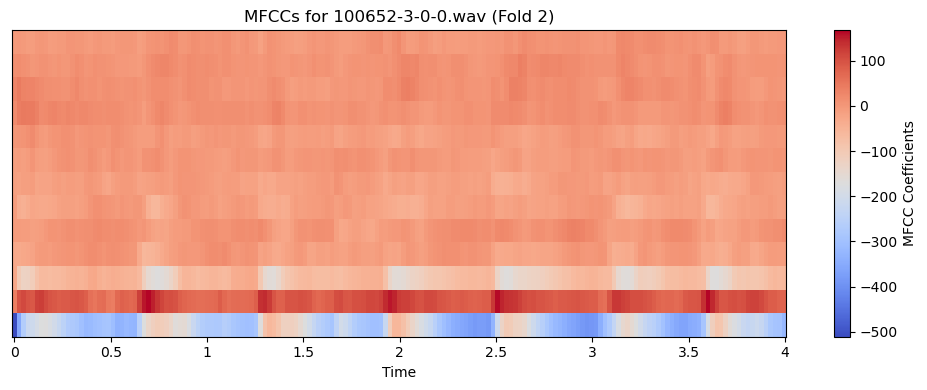

In [42]:
# Compute MFCCs for file using MFCC-13
n_mfcc = 13
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(label='MFCC Coefficients')
plt.title(f"MFCC-13 for {first_file} (Fold 2)")
plt.tight_layout()
plt.show()

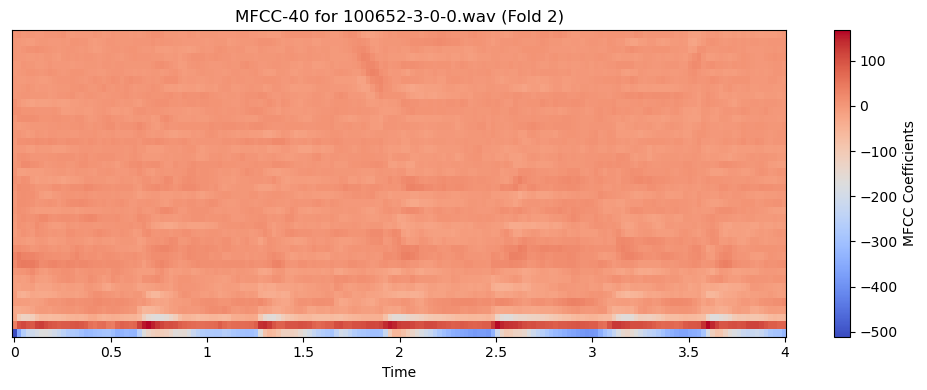

In [44]:
# Compute MFCCs for file using MFCC-40
n_mfcc = 40
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(label='MFCC Coefficients')
plt.title(f"MFCC-40 for {first_file} (Fold 2)")
plt.tight_layout()
plt.show()

Here we have two different plots using different number of MFCCs to extract more detail from the audio data. In both visuals, we can see a pattern of the same sound appearing every second or so very close to the x-axis. This is evident by the red spots we see consistently interrupting the horizontal blue line, which could represent some siren, horn, or dog barking that is interrupting the background noise. Let's check out the Mel-Spectrogram for this same audio clip.

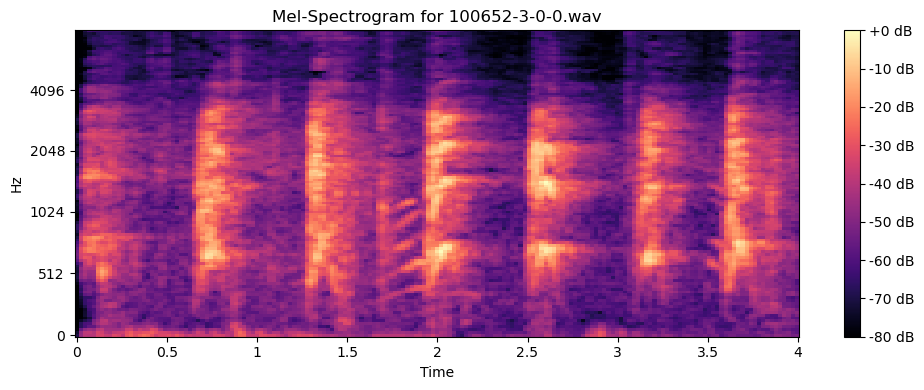

In [47]:
# Generate Mel-Spectrogram for same audio file
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_db = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram for {first_file}')
plt.tight_layout()
plt.show()

Pretty consistent with what we saw with the previous MFCC plots, we see a sharp sound every half second or so that is represented by the vertical yellow blobs. This typically indicates a repeating horn or bark. (I just listened to the audio clip for the first time and it is a dog barking, so this makes sense.) Let's examine a spectral centroid for this same audio clip.

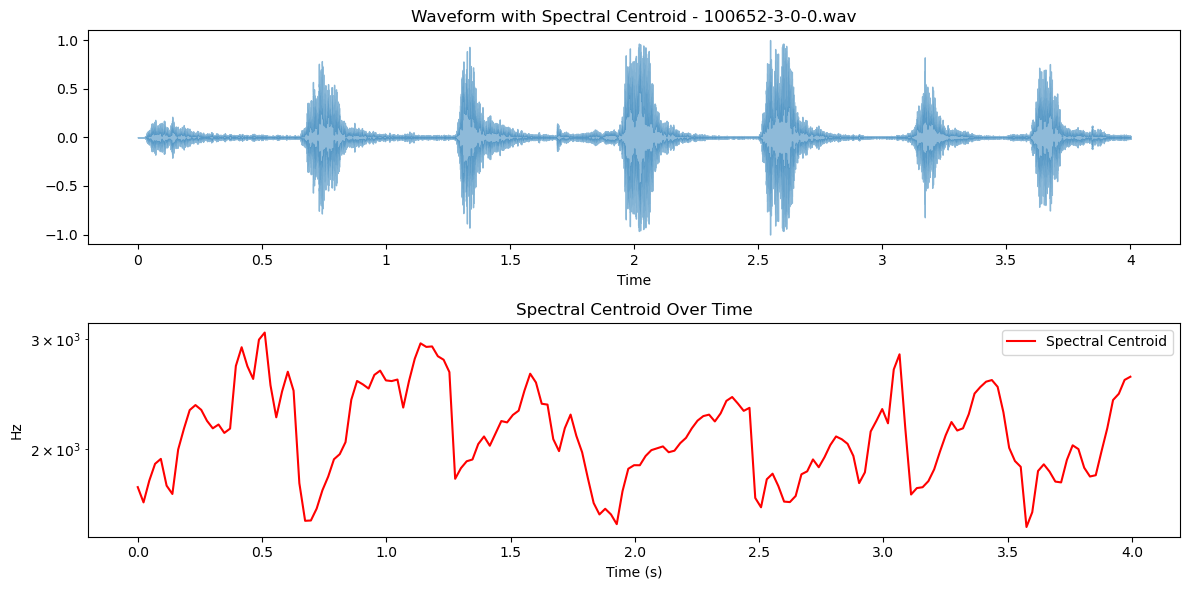

In [52]:
# Generate spectral centroid for audio clip
spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames, sr=sr)
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title(f"Waveform with Spectral Centroid - {first_file}")

plt.subplot(2, 1, 2)
plt.semilogy(t, spectral_centroids, label='Spectral Centroid', color='r')
plt.ylabel('Hz')
plt.xlabel('Time (s)')
plt.title('Spectral Centroid Over Time')
plt.tight_layout()
plt.legend()
plt.show()

In our spectral centroid plot, the peaks correspond to sharper sounds with higher frequencies. Since we already know the audio clip is a dog barking, these peaks are where the dog's bark occurs and stands out from the background noise.

### Modeling with CNNs

Let's create 1-D CNN using the raw waveform inputs and test on the preprocessed audio data.

In [61]:
# Set up paths for tensors
class UrbanSoundDataset(Dataset):
    def __init__(self, metadata_csv, audio_dir, folds=None, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        if folds is not None:
            self.metadata = self.metadata[self.metadata['fold'].isin(folds)]
        self.audio_dir = audio_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        fold = row.fold
        file_name = row.slice_file_name
        label = row.classID
        
        file_path = os.path.join(self.audio_dir, f"fold{fold}", file_name)
        waveform, sr = sf.read(file_path)
        
        # Ensure waveform is a 1D numpy array
        if waveform.ndim > 1:
            waveform = np.mean(waveform, axis=1)  # convert to mono by averaging channels
        
        # Convert to float32 tensor
        waveform = torch.tensor(waveform, dtype=torch.float32)
        
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform, label

In [63]:
# Audio file paths
metadata_path = "UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv"
audio_dir = "UrbanSound8K_fixedlen" 

# For example, use folds 1-8 for training, 9 for validation
train_folds = list(range(1, 9))
val_folds = [9]

train_dataset = UrbanSoundDataset(metadata_path, audio_dir, folds=train_folds)
val_dataset = UrbanSoundDataset(metadata_path, audio_dir, folds=val_folds)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [67]:
# Set up 1-D CNN model
class Simple1DCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=9, stride=1, padding=4)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=9, stride=1, padding=4)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.conv3 = nn.Conv1d(32, 64, kernel_size=9, stride=1, padding=4)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(64 * (22050 * 4 // (4*4*4)), 256)  # adjust based on input length and pooling
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = x.unsqueeze(1)  # add channel dim: (batch, 1, seq_len)
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [71]:
# Set up training loop for 1-D CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for waveforms, labels in loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(waveforms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * waveforms.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def validate_epoch(model, loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for waveforms, labels in loader:
            waveforms, labels = waveforms.to(device), labels.to(device)
            outputs = model(waveforms)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * waveforms.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

# Example training for 5 epochs
for epoch in range(5):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = validate_epoch(model, val_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Loss=3.5474, Train Acc=0.3125, Val Loss=1.7032, Val Acc=0.4081
Epoch 2: Train Loss=1.5718, Train Acc=0.4518, Val Loss=1.5946, Val Acc=0.4645
Epoch 3: Train Loss=1.3980, Train Acc=0.5044, Val Loss=1.5913, Val Acc=0.4779
Epoch 4: Train Loss=1.2575, Train Acc=0.5522, Val Loss=1.9565, Val Acc=0.3627
Epoch 5: Train Loss=1.1300, Train Acc=0.6029, Val Loss=1.5845, Val Acc=0.4375


We can see that through each iteration of the dataset, our CNN is achieving higher accuracy and lower losses. Let's take this 1-D CNN and evaluate it's performance on a test set of data (more specifically fold #10).

In [79]:
# Test CNN on fold 10
test_folds = [10]
test_dataset = UrbanSoundDataset(metadata_path, audio_dir, folds=test_folds)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for waveforms, labels in test_loader:
        waveforms, labels = waveforms.to(device), labels.to(device)
        outputs = model(waveforms)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy against Fold 10: {test_accuracy:.4f}")
print(classification_report(all_labels, all_preds, digits=4))

Test Accuracy: 0.4277
              precision    recall  f1-score   support

           0     0.1818    0.0400    0.0656       100
           1     0.3043    0.2121    0.2500        33
           2     0.2273    0.1000    0.1389       100
           3     0.4643    0.6500    0.5417       100
           4     0.6515    0.4300    0.5181       100
           5     0.5574    0.3656    0.4416        93
           6     0.5000    0.5625    0.5294        32
           7     0.4468    0.8750    0.5915        96
           8     0.5325    0.4940    0.5125        83
           9     0.2889    0.5200    0.3714       100

    accuracy                         0.4277       837
   macro avg     0.4155    0.4249    0.3961       837
weighted avg     0.4138    0.4277    0.3932       837



This 1-D CNN yields an overall accuracy score of 42.77% when tested against Fold 10. Out of the 10 different classifications of sounds in the dataset, this model had the hardest time successfully identifying Class 0, which is evident by the very low recall score. This 1-D CNN had the easiest time identifying audio files from Class 7, as it achieved a recall score of 87.50%. Let's see how a 2-D CNN performs using mel-spectrogram inputs.

In [82]:
# Set up for 2-D CNN using mel-spectrogram inputs
class UrbanSoundMelDataset(Dataset):
    def __init__(self, metadata_csv, audio_dir, folds=None, sr=22050, n_mels=128, fixed_duration=4.0, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        if folds is not None:
            self.metadata = self.metadata[self.metadata['fold'].isin(folds)]
        self.audio_dir = audio_dir
        self.sr = sr
        self.n_mels = n_mels
        self.fixed_length = int(sr * fixed_duration)
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        fold = row.fold
        file_name = row.slice_file_name
        label = row.classID
        
        file_path = os.path.join(self.audio_dir, f"fold{fold}", file_name)
        y, sr = librosa.load(file_path, sr=self.sr)
        
        # Pad or truncate to fixed length
        if len(y) > self.fixed_length:
            y = y[:self.fixed_length]
        elif len(y) < self.fixed_length:
            y = np.pad(y, (0, self.fixed_length - len(y)), mode='constant')
        
        # Compute mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels, fmax=sr//2)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # Normalize mel spectrogram (optional but common)
        mel_spec_db_norm = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-6)
        
        # Convert to tensor and add channel dim for CNN: (1, n_mels, time)
        mel_spec_tensor = torch.tensor(mel_spec_db_norm).unsqueeze(0).float()
        
        if self.transform:
            mel_spec_tensor = self.transform(mel_spec_tensor)
        
        return mel_spec_tensor, label

In [86]:
# Set up train/test data
train_folds = list(range(1, 9))
val_folds = [9]
test_folds = [10]

train_dataset = UrbanSoundMelDataset(metadata_path, audio_dir, folds=train_folds)
val_dataset = UrbanSoundMelDataset(metadata_path, audio_dir, folds=val_folds)
test_dataset = UrbanSoundMelDataset(metadata_path, audio_dir, folds=test_folds)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [90]:
# 2-D CNN model
class Simple2DCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 16 * 21, 256)  # adjust 21 if time dim is different
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        # x shape: (batch, 1, n_mels, time)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [92]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple2DCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Example training loop for multiple epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc = validate_epoch(model, val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10 — Train Loss: 1.6789, Train Acc: 0.5128 — Val Loss: 1.3426, Val Acc: 0.5870
Epoch 2/10 — Train Loss: 0.8199, Train Acc: 0.7267 — Val Loss: 1.3493, Val Acc: 0.6127
Epoch 3/10 — Train Loss: 0.4930, Train Acc: 0.8378 — Val Loss: 1.4810, Val Acc: 0.6593
Epoch 4/10 — Train Loss: 0.3658, Train Acc: 0.8809 — Val Loss: 1.7143, Val Acc: 0.6985
Epoch 5/10 — Train Loss: 0.2470, Train Acc: 0.9210 — Val Loss: 2.1276, Val Acc: 0.6471
Epoch 6/10 — Train Loss: 0.2055, Train Acc: 0.9316 — Val Loss: 2.2605, Val Acc: 0.6446
Epoch 7/10 — Train Loss: 0.1342, Train Acc: 0.9542 — Val Loss: 2.2015, Val Acc: 0.6777
Epoch 8/10 — Train Loss: 0.1465, Train Acc: 0.9534 — Val Loss: 2.2290, Val Acc: 0.6887
Epoch 9/10 — Train Loss: 0.1057, Train Acc: 0.9657 — Val Loss: 2.3250, Val Acc: 0.6863
Epoch 10/10 — Train Loss: 0.0873, Train Acc: 0.9713 — Val Loss: 2.4216, Val Acc: 0.6961


Similar to our 1-D CNN, we can see that with more epochs/iterations through the training set, our model is increasing accuracy. Let's see how this performs against the training set that is Fold 10.

In [95]:
# Evalute 2-D CNN on fold 10
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().cpu().numpy())

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optional: detailed classification report
print(classification_report(all_labels, all_preds, digits=4))

Test Accuracy: 0.7826
              precision    recall  f1-score   support

           0     0.8182    0.7200    0.7660       100
           1     0.9091    0.9091    0.9091        33
           2     0.6966    0.6200    0.6561       100
           3     0.6990    0.7200    0.7094       100
           4     0.8586    0.8500    0.8543       100
           5     0.6897    0.8602    0.7656        93
           6     1.0000    0.9375    0.9677        32
           7     0.7946    0.9271    0.8558        96
           8     0.9583    0.5542    0.7023        83
           9     0.7479    0.8900    0.8128       100

    accuracy                         0.7826       837
   macro avg     0.8172    0.7988    0.7999       837
weighted avg     0.7933    0.7826    0.7795       837



This 2-D CNN achieved an overall accuracy of 78.26%. It had the hardest time correctly identifying Class 8 audio files, but had the easiest time correctly identifying Class 6 audio files.

### 4) Comparative Evaluation

The 2-D CNN performed better overall, as it yielded an accuracy rate of 78.26%, while the 1-D CNN only achieved 42.77% accuracy. The 1-D CNN struggled to successfully identify Class 0 audio files, as it correctly predicted only 4% of those. However, the 2-D CNN did much better with the Class 0 audio files, as it correctly predicted those about 72% of the time. Across the board, the 2-D CNN was able to generalize and perform better than the initial 1-D CNN. Also, the 1-D CNN converged at a slower rate with less accuracy compared to the 2-D CNN.

### 5) Interpretability and Limitations

The 2-D CNN using the mel-spectrogram inputs performed way better than the 1-D CNN that used the raw waveform inputs because the mel-spectrogram input provides way more useful information than the raw waveforms do. The 1-D CNN has to do extra processing to make the raw waveforms usable to learn from, while the mel-spectrogram inputs were already preprocessed and ready to learn from. Also, the raw waveforms only contain one dimensional data (amplitude time series), while the mel-spectrogram input provides two dimensional data (time and frequency). To improve performance, future work could include adding additional convolutional layers to the CNNs or combining the two models (1-D and 2-D CNN making up one model).